In [14]:
import torch
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import math

### 使用三阶多项式生成训练和测试数据标签
$$ y = 5 + 1.2x -3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \varepsilon where \varepsilon ~ N(0.01^2)$$

In [15]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

In [16]:
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [17]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.1374],
         [-2.3038]]),
 tensor([[ 1.0000e+00,  1.1374e+00,  6.4679e-01,  2.4521e-01,  6.9723e-02,
           1.5860e-02,  3.0064e-03,  4.8848e-04,  6.9448e-05,  8.7763e-06,
           9.9818e-07,  1.0321e-07,  9.7820e-09,  8.5582e-10,  6.9527e-11,
           5.2718e-12,  3.7475e-13,  2.5072e-14,  1.5842e-15,  9.4831e-17],
         [ 1.0000e+00, -2.3038e+00,  2.6537e+00, -2.0379e+00,  1.1737e+00,
          -5.4079e-01,  2.0764e-01, -6.8338e-02,  1.9680e-02, -5.0375e-03,
           1.1605e-03, -2.4305e-04,  4.6662e-05, -8.2692e-06,  1.3607e-06,
          -2.0899e-07,  3.0092e-08, -4.0780e-09,  5.2193e-10, -6.3285e-11]]),
 tensor([  5.3788, -18.2934]))

In [18]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [19]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

RuntimeError: grad can be implicitly created only for scalar outputs

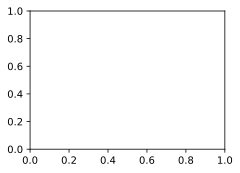

In [20]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

RuntimeError: grad can be implicitly created only for scalar outputs

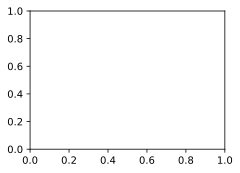

In [13]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)